In [1]:
import mitsuba as mi
import numpy as np
import drjit as dr
import matplotlib.pyplot as plt

In [2]:
mi.set_variant('cuda_ad_rgb')

In [3]:
scene = mi.load_file('data/simple.xml')

Ray Generation

In [4]:
params = mi.traverse(scene)

In [5]:
# Camera origin in world space
cam_origin = mi.Point3f(0, -12, 5)

# Camera view direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, 0, 1.25) - cam_origin)

# Camera width and height in world space
cam_width  = 6.0
cam_height = 6.0

# Image pixel resolution
image_res = [256, 256]

In [6]:
# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width  / 2,   cam_width / 2, image_res[0]),
    dr.linspace(mi.Float, -cam_height / 2,  cam_height / 2, image_res[1])
)

# Ray origin in local coordinates
ray_origin_local = mi.Vector3f(x, y, 0)

# Ray origin in world coordinates
ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin

ray = mi.Ray3f(o=ray_origin, d=cam_dir)

# TODO: Prism can be intersected here
# TODO: OpenCL-based RayTracing project is broken (assets were not correctly pushed to github repo)
# TODO: Figure out how to store ray intersection point to build space-time hit record
si = scene.ray_intersect(ray)

In [16]:
help(scene.ray_intersect)

Help on method ray_intersect in module mitsuba.cuda_ad_rgb:

ray_intersect(...) method of mitsuba.cuda_ad_rgb.Scene instance
    ray_intersect(*args, **kwargs)
    Overloaded function.
    
    1. ray_intersect(self: mitsuba.cuda_ad_rgb.Scene, ray: mitsuba.cuda_ad_rgb.Ray3f, active: drjit.cuda.ad.Bool = True) -> mitsuba::SurfaceInteraction<drjit::DiffArray<drjit::CUDAArray<float> >,mitsuba::Color<drjit::DiffArray<drjit::CUDAArray<float> >,3> >
    
    Intersect a ray with the shapes comprising the scene and return a
    detailed data structure describing the intersection, if one is found.
    
    In vectorized variants of Mitsuba (``cuda_*`` or ``llvm_*``), the
    function processes arrays of rays and returns arrays of surface
    interactions following the usual conventions.
    
    This method is a convenience wrapper of the generalized version of
    ``ray_intersect``() below. It assumes that incoherent rays are being
    traced, and that the user desires access to all fields of

In [7]:
ambient_range = 0.75
ambient_ray_count = 256

# Initialize the random number generator
rng = mi.PCG32(size=dr.prod(image_res))

In [8]:
# Loop iteration counter
i = mi.UInt32(0)

# Accumulated result
result = mi.Float(0)

# Initialize the loop state (listing all variables that are modified inside the loop)
loop = mi.Loop(name="", state=lambda: (rng, i, result))

while loop(si.is_valid() & (i < ambient_ray_count)):
    # 1. Draw some random numbers
    sample_1, sample_2 = rng.next_float32(), rng.next_float32()

    # 2. Compute directions on the hemisphere using the random numbers
    wo_local = mi.warp.square_to_uniform_hemisphere([sample_1, sample_2])

    # Alternatively, we could also sample a cosine-weighted hemisphere
    # wo_local = mi.warp.square_to_cosine_hemisphere([sample_1, sample_2])

    # 3. Transform the sampled directions to world space
    wo_world = si.sh_frame.to_world(wo_local)

    # 4. Spawn a new ray starting at the surface interactions
    ray_2 = si.spawn_ray(wo_world)

    # 5. Set a maximum intersection distance to only account for the close-by geometry
    ray_2.maxt = ambient_range

    # 6. Accumulate a value of 1 if not occluded (0 otherwise)
    result[~scene.ray_test(ray_2)] += 1.0

    # 7. Increase loop iteration counter
    i += 1

# Divide the result by the number of samples
result = result / ambient_ray_count

In [9]:
image = mi.TensorXf(result, shape=image_res)

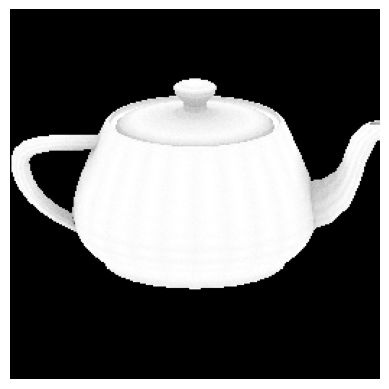

In [10]:
plt.axis("off")
plt.imshow(image ** (1.0 / 2.2), cmap='gray'); # approximate sRGB tonemapping